# 02 - Modelo Inicial
Repositorio: [github.com/MateoRomano02/tp_equidad](https://github.com/MateoRomano02/tp_equidad)


Este notebook corresponde al punto N°2, N°3 y N°4 del TP

## Objetivo
Entrenar un modelo de clasificación sobre el dataset *German Credit Data* y evaluar su rendimiento con métricas como accuracy, precision, recall y F1-score. Además, se analizará cuál error es más costoso para el banco.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from holisticai.bias.mitigation import Reweighing
from holisticai.pipeline import Pipeline as HolPipeline
from holisticai.bias.mitigation import CorrelationRemover
from holisticai.bias.mitigation import PrejudiceRemover
from holisticai.bias.metrics import classification_bias_metrics

## Carga de datos

In [3]:

df = pd.read_csv("..\data\processed\south_german_credit_clean.csv")

df.head()


,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,other_debtors,present_residence,...,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,target,sex,personal_status
0,no checking account,9,all credits at this bank paid back duly,others,2799,unknown/no savings account,1 <= ... < 4 yrs,25 <= ... < 35,none,1 <= ... < 4 yrs,...,none,for free,2-3,skilled employee/official,3 or more,no,no,good,male,non-single
1,no checking account,12,all credits at this bank paid back duly,others,2122,unknown/no savings account,1 <= ... < 4 yrs,20 <= ... < 25,none,1 <= ... < 4 yrs,...,none,for free,2-3,unskilled - resident,3 or more,no,yes,good,male,non-single
2,no checking account,12,all credits at this bank paid back duly,others,2171,unknown/no savings account,1 <= ... < 4 yrs,< 20,none,>= 7 yrs,...,bank,rent,2-3,unskilled - resident,0 to 2,no,yes,good,male,non-single
3,no checking account,10,all credits at this bank paid back duly,others,2241,unknown/no savings account,< 1 yr,>= 35,none,4 <= ... < 7 yrs,...,none,for free,2-3,unskilled - resident,3 or more,no,yes,good,male,non-single
4,no checking account,8,all credits at this bank paid back duly,others,3398,unknown/no savings account,4 <= ... < 7 yrs,>= 35,none,>= 7 yrs,...,none,rent,2-3,unskilled - resident,0 to 2,no,yes,good,male,non-single


## Modelo baseline

Vamos a entrenar un *Árbol de Decisión* porque es fácil de entender y nos parece adecuado para un primer modelo.

Por el desbalance de clases, conviene usar SMOTE y de paso podemos armar un pipeline para buscar buenos parámetros con Grid Search y validación cruzada.

In [4]:
# Separar features y target
X = df.drop(columns=["target"])
y = df["target"].map({"good": 1, "bad": 0})  # good = positivo (1), bad = negativo (0)

# Codificar variables categóricas
X = pd.get_dummies(X, drop_first=True)

# Dividir en train/test (30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Pipeline con SMOTE + Árbol + GridSearch
pipeline = ImbPipeline([
    ("smote", SMOTE(random_state=42)),
    ("scaler", StandardScaler()),  # No es estrictamente necesario para árboles, pero lo incluye por buenas prácticas
    ("clf", DecisionTreeClassifier(random_state=42))
])

# Definir los hiperparámetros a buscar
param_grid = {
    "clf__max_depth": [3, 5, 10, None],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 5],
    "clf__criterion": ["gini", "entropy"]
}

# GridSearch con validación cruzada
grid_search = GridSearchCV(
    pipeline, param_grid, scoring="f1", cv=5, n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Predicciones
y_pred = grid_search.predict(X_test)

# Métricas
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=["bad (0)", "good (1)"])
best_params = grid_search.best_params_

Mejores hiperparámetros encontrados por GridSearch:
  clf__criterion: gini
  clf__max_depth: 10
  clf__min_samples_leaf: 5
  clf__min_samples_split: 2

Reporte de clasificación en test:
              precision    recall  f1-score   support

     bad (0)       0.45      0.49      0.47        90
    good (1)       0.77      0.74      0.76       210

    accuracy                           0.67       300
   macro avg       0.61      0.62      0.61       300
weighted avg       0.68      0.67      0.67       300



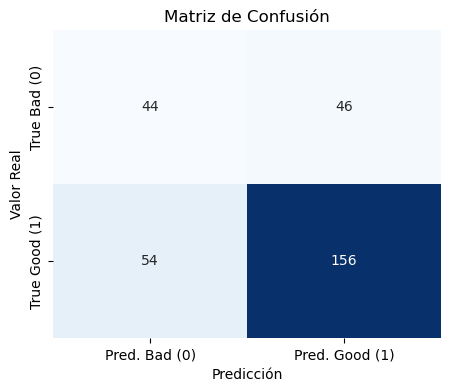

In [5]:
# print de las métrcias

print("Mejores hiperparámetros encontrados por GridSearch:")
for k, v in best_params.items():
    print(f"  {k}: {v}")
print("\nReporte de clasificación en test:")
print(class_report)

# Plot de la matriz de confusión
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Pred. Bad (0)", "Pred. Good (1)"],
            yticklabels=["True Bad (0)", "True Good (1)"])
plt.title("Matriz de Confusión")
plt.ylabel("Valor Real")
plt.xlabel("Predicción")
plt.show()

## Análisis de errores y trade-off

En el contexto bancario, donde el objetivo es **maximizar los préstamos otorgados a personas que efectivamente los van a pagar**, el **falso positivo** (darle un préstamo a alguien que no lo va a pagar) puede representar una **pérdida financiera** significativa.

En cambio, un **falso negativo** (negarle un préstamo a alguien que sí lo iba a pagar) implica una oportunidad perdida, pero no un costo directo. Por eso, **los falsos positivos son el error más costoso** en este escenario.

Esto debería reflejarse en el umbral de decisión y posiblemente en la elección de métricas (por ejemplo, priorizar un FPR bajo).


# 03 - Evaluación de equidad del modelo inicial


## Descripcion de las metricas de fairness vistas en clase para este contexto

1)Statistical Parity:
La proporcion de creditos aprobados de ambos grupos analizados debe ser estar dentro de nuestro criterio de comparacion.
Independientemente de la proporcion de buenos pagadores en ambos grupos, la prediccion positiva deberia ser la misma.

2)Equalized Odds:
La tasa de TPR y FPR debe ser la misma en ambos grupos.Es decir que el modelo se equivoca y acierta en la misma proporcion para ambos grupos, con respecto a la aprobacion
de creditos en ambos grupos.

3)Equal Opportunity:
El modelo se asegura de que en solo el caso de quienes si pagarian el prestamo, sea igual la proporcion de aprobados crediticiamente para los dos grupos.

4)Predictive Parity:
Se busca que la calidad de aprobaciones sea equitativa para ambos grupos.

## Analisis de fairness en el modelo anterior

 El umbral que nosotros proponemos para la diferencia del modulo entre las metricas de ambos grupos es el del 0.08 (8%)

## Obtencion de las metricas

### con Holistic Ai:

In [6]:
from holisticai.bias.metrics import classification_bias_metrics

df_eval = X_test.copy()
df_eval["y_true"] = y_test
df_eval["y_pred"] = y_pred
# Para el modelo base (sin mitigación)
metrics_base = classification_bias_metrics(
    df_eval["sex_male"] == True,
    df_eval["sex_male"] == False,
    y_pred,
    y_test,
    metric_type="both"
)

print("Métricas de fairness (modelo base):")
print(metrics_base)

Métricas de fairness (modelo base):
                                       Value  Reference
Metric                                                 
Statistical Parity                 -0.018301          0
Disparate Impact                    0.973435          1
Four Fifths Rule                    0.973435          1
Cohen D                            -0.039023          0
2SD Rule                           -0.241332          0
Equality of Opportunity Difference -0.098304          0
False Positive Rate Difference      0.089527          0
Average Odds Difference            -0.004389          0
Accuracy Difference                -0.078431          0


## Conclusiones de los resultados de las metricas

Cumple `Statistical Parity`, `Predictive Parity`, pero tiene una diferencia de `FPR` alta y no cumple `Equal Opportunity` (por ende tampoco `Equalized Odds`)

## Elección del criterio de fairness

Nosotros elegimos el criterio de `Equalized Odds` debido a que como personal del banco tenemos que encontrar un balance que no perjudique a los clientes pero tampoco a nuestra institucion:

Los clientes que si pagarán son aprobados en las mismas probabilidades entre hombres y mujeres.
Mientras que los que no pagarian, son rechazados en la misma probabilidad para los dos grupos. Esta medida haria el modelo mas confiable desde una perspectiva bancaria.

# 04 - Modelos con Mitigación de Sesgos

## *Funcion de plots y métricas*

In [9]:
def mostrar_metricas_y_matriz_confusion(y_true, y_pred, group_a, group_b, nombre_modelo="Modelo"):
    """
    Imprime las métricas de fairness y muestra la matriz de confusión para un modelo dado.
    
    Parámetros:
    - y_true: valores reales
    - y_pred: predicciones del modelo
    - group_a: grupo sensible A (ej: X_test["sex_male"])
    - group_b: grupo sensible B (ej: ~X_test["sex_male"])
    - nombre_modelo: nombre a mostrar en el título del gráfico
    """
    from holisticai.bias.metrics import classification_bias_metrics
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Fairness metrics
    metrics = classification_bias_metrics(
        group_a,
        group_b,
        y_pred,
        y_true,
        metric_type='both'
    )
    print(f"Métricas de fairness ({nombre_modelo}):")
    print(metrics)

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["bad", "good"],
                yticklabels=["bad", "good"])
    plt.xlabel("Predicción")
    plt.ylabel("Valor real")
    plt.title(f"Matriz de Confusión - {nombre_modelo}")
    plt.tight_layout()
    plt.show()

    class_report = classification_report(y_true, y_pred, target_names=["bad (0)", "good (1)"])
    print("\nReporte de clasificación:")
    print(class_report)

## Pre-processing

### Reweighting

Comparar p esperado y el observado

In [10]:
print(f"P Esperado: ",((X_train['sex_male']==False).sum()/len(X_train))*((pd.DataFrame(y_train)["target"]==1).sum()/len(y_train)))

P Esperado:  0.11699999999999999


In [11]:
acum=0
for index in X_train.index.to_list():
  if pd.DataFrame(y_train)["target"].loc[index]==1 and X_train["sex_male"].loc[index]==False:
    acum+=1
print(f"P Observado: ",acum/len(X_train))

P Observado:  0.11


Aplicamos el mitigador

In [12]:
mitigador_w = Reweighing()
modelo_w=DecisionTreeClassifier(criterion="gini", max_depth=10, min_samples_leaf=5, min_samples_split=2, random_state=42)
pipeline_W = HolPipeline(steps=[("bm_preprocessing", mitigador_w), ("estimator", modelo_w),])
pipeline_W.fit(X_train,y_train, bm__group_a=X_train["sex_male"], bm__group_b=~X_train["sex_male"])
y_pred_weight = pipeline_W.predict(X_test, bm__group_a=X_test["sex_male"], bm__group_b=~X_test["sex_male"])


Calculamos metricas

Métricas de fairness (Modelo con Reweighing):
                                       Value  Reference
Metric                                                 
Statistical Parity                  0.001307          0
Disparate Impact                    1.001898          1
Four Fifths Rule                    0.998106          1
Cohen D                             0.002826          0
2SD Rule                            0.017480          0
Equality of Opportunity Difference  0.094875          0
False Positive Rate Difference     -0.228041          0
Average Odds Difference            -0.066583          0
Accuracy Difference                 0.158170          0


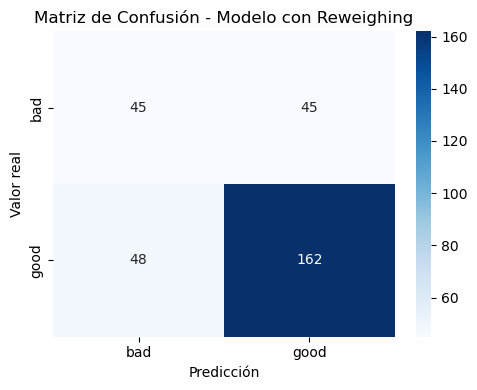


Reporte de clasificación:
              precision    recall  f1-score   support

     bad (0)       0.48      0.50      0.49        90
    good (1)       0.78      0.77      0.78       210

    accuracy                           0.69       300
   macro avg       0.63      0.64      0.63       300
weighted avg       0.69      0.69      0.69       300



In [13]:
mostrar_metricas_y_matriz_confusion(y_test, y_pred_weight, X_test['sex_male'], ~X_test['sex_male'], nombre_modelo="Modelo con Reweighing")

Mejoró un poco el TPR pero empeoró un montón el FPR

### Correlation remover

Buscamos correlaciones

C:\Users\lean3\AppData\Local\Temp\ipykernel_15232\257248036.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_num["sex"] = df["sex"].map({"male": 1, "female": 0})


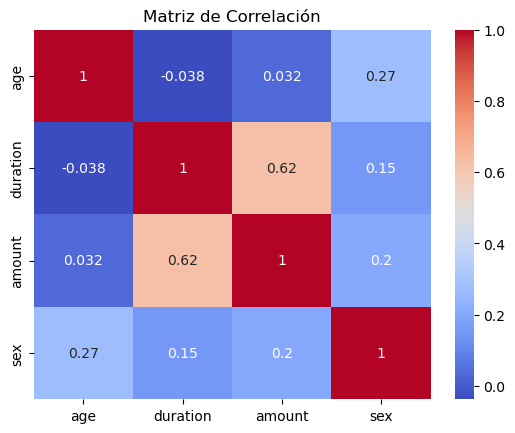

In [14]:
X_num=df[["age","duration","amount","sex"]]
X_num["sex"] = df["sex"].map({"male": 1, "female": 0})

corr = X_num.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Matriz de Correlación")
plt.show()


Hay

In [15]:
mitigador_cr = CorrelationRemover()
modelo_cr=DecisionTreeClassifier(criterion="gini", max_depth=10, min_samples_leaf=5, min_samples_split=2, random_state=42)
pipeline_cr = HolPipeline(steps=[("bm_preprocessing", mitigador_cr), ("estimator", modelo_cr),])
pipeline_cr.fit(X_train[["age","duration","amount"]],y_train, bm__group_a=X_train["sex_male"], bm__group_b=~X_train["sex_male"])
y_pred_cr = pipeline_cr.predict(X_test[["age","duration","amount"]], bm__group_a=X_test["sex_male"], bm__group_b=~X_test["sex_male"])

Métricas de fairness (Modelo con Correlation Remover):
                                       Value  Reference
Metric                                                 
Statistical Parity                  0.000000          0
Disparate Impact                    1.000000          1
Four Fifths Rule                    1.000000          1
Cohen D                             0.000000          0
2SD Rule                            0.000000          0
Equality of Opportunity Difference  0.071442          0
False Positive Rate Difference     -0.168919          0
Average Odds Difference            -0.048738          0
Accuracy Difference                 0.130719          0


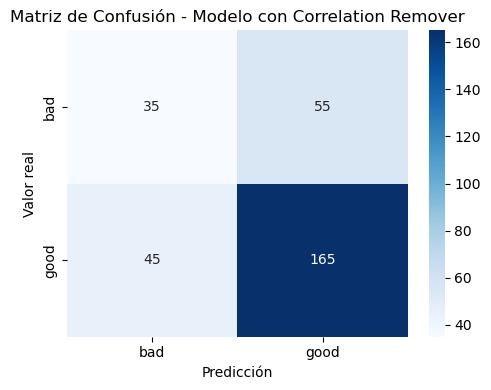


Reporte de clasificación:
              precision    recall  f1-score   support

     bad (0)       0.44      0.39      0.41        90
    good (1)       0.75      0.79      0.77       210

    accuracy                           0.67       300
   macro avg       0.59      0.59      0.59       300
weighted avg       0.66      0.67      0.66       300



In [16]:
mostrar_metricas_y_matriz_confusion(y_test, y_pred_cr, X_test['sex_male'], ~X_test['sex_male'], nombre_modelo="Modelo con Correlation Remover")

Mejoró bastante el Equal Opportunity, ahora está dentro del umbral. Sin embargo el FPRD todavía es peor que el baseline

## In-processing

### Prejudice Remover

Vamos con un modelo con mitigacion in-processing. Para esto introducimos Prejudice Remover pero esta vez tenemos que aplicarlo en un regresor logístico por la naturaleza de este método de mitigación:

Baseline logistic regression:

In [17]:
from sklearn.linear_model import LogisticRegression

# Entrenar modelo baseline LogisticRegression
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)

# Predicciones
y_pred_logreg = logreg.predict(X_test)

# Métricas

# Evaluate bias metrics for pipeline model
metrics_inprocessing_lr = classification_bias_metrics(
    X_test['sex_male'], 
    ~X_test['sex_male'], 
    y_pred_logreg, 
    y_test, 
    metric_type='both')

print(metrics_inprocessing_lr)

                                       Value  Reference
Metric                                                 
Statistical Parity                  0.071895          0
Disparate Impact                    1.104364          1
Four Fifths Rule                    0.905498          1
Cohen D                             0.166362          0
2SD Rule                            1.026872          0
Equality of Opportunity Difference -0.016765          0
False Positive Rate Difference      0.179054          0
Average Odds Difference             0.081144          0
Accuracy Difference                -0.048366          0


c:\Users\lean3\anaconda3\envs\pymc_env\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Prejudice Remover:

[elapsed time: 00:00:00 | iter:17/100 | loss:283.6373]
[elapsed time: 00:00:00 | Best Loss : 283.6373]
Métricas de fairness (Modelo con Prejudice Remover):
                                       Value  Reference
Metric                                                 
Statistical Parity                  0.026144          0
Disparate Impact                    1.036765          1
Four Fifths Rule                    0.964539          1
Cohen D                             0.059137          0
2SD Rule                            0.365636          0
Equality of Opportunity Difference  0.104591          0
False Positive Rate Difference     -0.173986          0
Average Odds Difference            -0.034698          0
Accuracy Difference                 0.151634          0


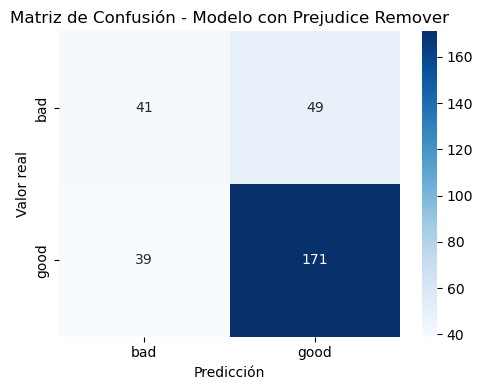


Reporte de clasificación:
              precision    recall  f1-score   support

     bad (0)       0.51      0.46      0.48        90
    good (1)       0.78      0.81      0.80       210

    accuracy                           0.71       300
   macro avg       0.64      0.63      0.64       300
weighted avg       0.70      0.71      0.70       300



In [18]:
import warnings
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings('ignore')

modelo_pr = LogisticRegression()
mitigator = PrejudiceRemover(maxiter=100, fit_intercept=True, verbose=1, print_interval=1).transform_estimator(modelo_pr)


# Define pipeline
pipeline_pr = HolPipeline(steps=[('scalar', StandardScaler()), ('bm_inprocessing', mitigator)])
pipeline_pr.fit(X_train,y_train, bm__group_a=X_train["sex_male"], bm__group_b=~X_train["sex_male"])

# Make predictions
y_pred_pipeline_pr = pipeline_pr.predict(X_test, bm__group_a=X_test["sex_male"], bm__group_b=~X_test["sex_male"])

# Evaluate bias metrics for pipeline model
mostrar_metricas_y_matriz_confusion(y_test, y_pred_pipeline_pr, X_test['sex_male'], ~X_test['sex_male'], nombre_modelo="Modelo con Prejudice Remover")

Nos da peores métricas que el baseline si nos fijamos solo en Equalized Odds

## Post-processing

### MLDebiaser

[elapsed time: 00:00:00 | iter:2/2]
Métricas de fairness (Modelo con mldebiaser):
                                       Value  Reference
Metric                                                 
Statistical Parity                 -0.035294          0
Disparate Impact                    0.951872          1
Four Fifths Rule                    0.951872          1
Cohen D                            -0.077289          0
2SD Rule                           -0.477863          0
Equality of Opportunity Difference -0.003048          0
False Positive Rate Difference     -0.152027          0
Average Odds Difference            -0.077538          0
Accuracy Difference                 0.069281          0


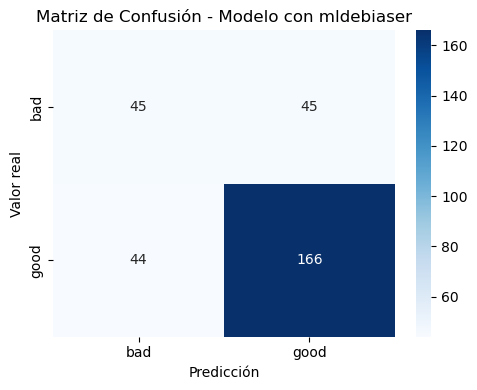


Reporte de clasificación:
              precision    recall  f1-score   support

     bad (0)       0.51      0.50      0.50        90
    good (1)       0.79      0.79      0.79       210

    accuracy                           0.70       300
   macro avg       0.65      0.65      0.65       300
weighted avg       0.70      0.70      0.70       300



In [19]:
from holisticai.bias.mitigation import MLDebiaser

# Definir el mitigador post-processing
mitigator = MLDebiaser()

# Definir el modelo base
model = DecisionTreeClassifier(criterion="gini", max_depth=10, min_samples_leaf=5, min_samples_split=2, random_state=42)

# Crear el pipeline con HolisticAI
pipeline_ml_debiaser = HolPipeline(steps=[
    ('scalar', StandardScaler()),
    ("estimator", model),
    ("bm_posprocessing", mitigator)
])

# Entrenar el pipeline
pipeline_ml_debiaser.fit(
    X_train, y_train,
    bm__group_a=X_train["sex_male"],
    bm__group_b=~X_train["sex_male"]
)

# Realizar predicciones
y_pred_ml_debiaser = pipeline_ml_debiaser.predict(
    X_test,
    bm__group_a=X_test["sex_male"],
    bm__group_b=~X_test["sex_male"]
)

# Calcular métricas de fairness
mostrar_metricas_y_matriz_confusion(y_test, y_pred_ml_debiaser, X_test['sex_male'], ~X_test['sex_male'], nombre_modelo="Modelo con mldebiaser")

Con este último el Equal Opportunity quedó excelente, pero el FPRD sigue siendo peor que el baseline

# 05 - Conclusiones

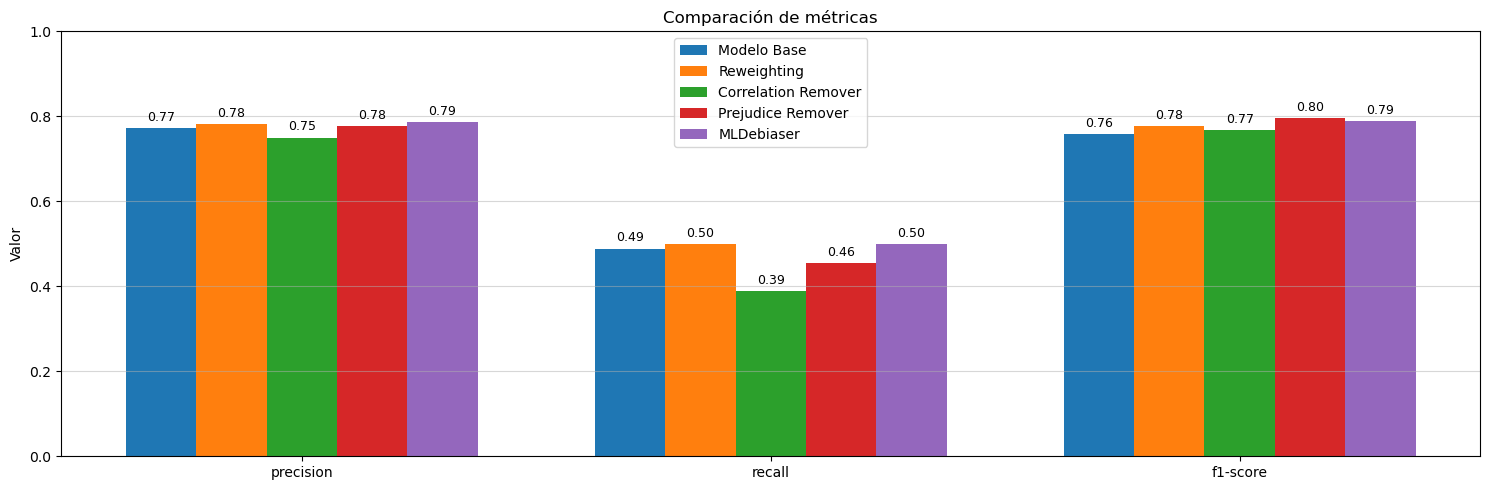

In [20]:
# Comparación de métricas de desempeño - Clase 1 para todos los modelos (recall clase "bad (0)")

labels = ['precision', 'recall', 'f1-score']
clase = 'good (1)'
clase_bad = 'bad (0)'

# Reportes de clasificación para cada modelo
report_base = classification_report(y_test, y_pred, target_names=["bad (0)", "good (1)"], output_dict=True, zero_division=0)
report_reweighting = classification_report(y_test, y_pred_weight, target_names=["bad (0)", "good (1)"], output_dict=True, zero_division=0)
report_corr = classification_report(y_test, y_pred_cr, target_names=["bad (0)", "good (1)"], output_dict=True, zero_division=0)
report_pr = classification_report(y_test, y_pred_pipeline_pr, target_names=["bad (0)", "good (1)"], output_dict=True, zero_division=0)
report_ml_debiaser = classification_report(y_test, y_pred_ml_debiaser, target_names=["bad (0)", "good (1)"], output_dict=True, zero_division=0)

# Extraer valores para cada métrica y modelo
values_base = [report_base[clase][metric] if metric != 'recall' else report_base[clase_bad]['recall'] for metric in labels]
values_w = [report_reweighting[clase][metric] if metric != 'recall' else report_reweighting[clase_bad]['recall'] for metric in labels]
values_corr = [report_corr[clase][metric] if metric != 'recall' else report_corr[clase_bad]['recall'] for metric in labels]
values_pr = [report_pr[clase][metric] if metric != 'recall' else report_pr[clase_bad]['recall'] for metric in labels]
values_ml_debiaser = [report_ml_debiaser[clase][metric] if metric != 'recall' else report_ml_debiaser[clase_bad]['recall'] for metric in labels]

# Configuración del gráfico
x = np.arange(len(labels))
width = 0.15

plt.figure(figsize=(15, 5))
bars1 = plt.bar(x - 2*width, values_base, width, label='Modelo Base')
bars2 = plt.bar(x - width, values_w, width, label='Reweighting')
bars3 = plt.bar(x, values_corr, width, label='Correlation Remover')
bars4 = plt.bar(x + width, values_pr, width, label='Prejudice Remover')
bars5 = plt.bar(x + 2*width, values_ml_debiaser, width, label='MLDebiaser')

# Agregar valores encima de cada barra
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.2f}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 puntos de desplazamiento vertical
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=9)

for bars in [bars1, bars2, bars3, bars4, bars5]:
    autolabel(bars)

plt.xticks(x, labels)
plt.ylim(0, 1)
plt.ylabel('Valor')
plt.title('Comparación de métricas')
plt.legend()
plt.grid(axis='y', linestyle='-', alpha=0.5)
plt.tight_layout()
plt.show()

El `recall` que se muestra en el plot corresponde con la clase `bad`.

In [21]:
# Comparación tabular de métricas de fairness y desempeño para todos los modelos

keys = [
    'Modelo Base',
    'Reweighting',
    'Correlation Remover',
    'Prejudice Remover',
    'MLDebiaser'
]

def get_metrics(y_true, y_pred, group_a, group_b):
    bias_metrics = classification_bias_metrics(
        group_a, group_b, y_pred, y_true, metric_type='both'
    )
    # Extraer métricas
    def get_metric_row(metric_name):
        row = bias_metrics.loc[metric_name]
        if isinstance(row, pd.Series):
            return row.iloc[0] if len(row) else np.nan
        return row
    sp = get_metric_row('Statistical Parity')
    eod = get_metric_row('Equality of Opportunity Difference')
    fprd = get_metric_row('False Positive Rate Difference')
    accd = get_metric_row('Accuracy Difference')
    # Extraer métricas de desempeño
    report = classification_report(y_true, y_pred, target_names=["bad (0)", "good (1)"], output_dict=True, zero_division=0)
    precision_good = report['good (1)']['precision']
    recall_bad = report['bad (0)']['recall']
    return pd.Series({
        'Statistical Parity': sp,
        'Equality of Opportunity Difference': eod,
        'False Positive Rate Difference': fprd,
        'Accuracy Difference': accd,
        'Precision (good)': precision_good,
        'Recall (bad)': recall_bad
    })

metrics_base = get_metrics(y_test, y_pred, X_test['sex_male'], ~X_test['sex_male'])
metrics_w = get_metrics(y_test, y_pred_weight, X_test['sex_male'], ~X_test['sex_male'])
metrics_corr = get_metrics(y_test, y_pred_cr, X_test['sex_male'], ~X_test['sex_male'])
metrics_pr = get_metrics(y_test, y_pred_pipeline_pr, X_test['sex_male'], ~X_test['sex_male'])
metrics_ml_debiaser = get_metrics(y_test, y_pred_ml_debiaser, X_test['sex_male'], ~X_test['sex_male'])

comparison = pd.concat(
    [metrics_base, metrics_w, metrics_corr, metrics_pr, metrics_ml_debiaser],
    axis=1
)
comparison.columns = keys
comparison['Referencia'] = comparison['Modelo Base']

comparison

,Modelo Base,Reweighting,Correlation Remover,Prejudice Remover,MLDebiaser,Referencia
Statistical Parity,-0.018301,0.001307,0.000000,0.026144,-0.035294,-0.018301
Equality of Opportunity Difference,-0.098304,0.094875,0.071442,0.104591,-0.003048,-0.098304
False Positive Rate Difference,0.089527,-0.228041,-0.168919,-0.173986,-0.152027,0.089527
Accuracy Difference,-0.078431,0.158170,0.130719,0.151634,0.069281,-0.078431
Precision (good),0.772277,0.782609,0.750000,0.777273,0.786730,0.772277
Recall (bad),0.488889,0.500000,0.388889,0.455556,0.500000,0.488889


Luego de aplicar distintas técnicas de mitigación de sesgo al modelo base, se observa una mejora significativa en varias métricas de equidad sin comprometer de forma crítica el rendimiento del modelo.

- **`MLDebiaser`** resultó ser el método más *balanceado*, mejorando las métricas de justicia (especialmente *Equality of Opportunity* y *Accuracy Difference*) sin deteriorar el rendimiento predictivo. De hecho, mostró una leve mejora tanto en *precision* como en *recall*.

- **`Correlation Remover`** fue el más efectivo en términos de *paridad estadística absoluta*, logrando un valor exactamente nulo en *Statistical Parity Difference*. Sin embargo, esta mejora fue un *trade-off* con el descenso en el *recall*.

- **`Reweighting`** y **`Prejudice Remover`** mostraron buen desempeño en algunas métricas, pero tendieron a *sobrecompensar* el sesgo original, introduciendo diferencias negativas en tasas de falsos positivos o disminuyendo la calidad general del modelo.

---

**El objetivo principal es optimizar `Equalized Odds`**

Se prioriza minimizar tanto la diferencia en la **tasa de falsos positivos** como en la **tasa de verdaderos positivos** (*Equality of Opportunity*). Bajo este criterio, se observa que **`Prejudice Remover`** y **`MLDebiaser`** son los métodos que logran el mejor equilibrio.

---

**Próximos pasos**:

- *Explorar variantes del modelo base* (por ejemplo, `RandomForestClassifier` o `GradientBoostingClassifier`) para evaluar si se puede mantener o incluso mejorar la equidad sin sacrificar precisión.

- *Afinar hiperparámetros del mitigador*, en este caso `Prejudice Remover`, que si bien mostró buenos resultados, parece estar sobrecompensando el sesgo. Ajustar sus parámetros podría ayudar a lograr un mejor balance entre equidad y desempeño.
